Computing geonu fluxes with the Earth models I used previously is very inefficient, so I will try to make some changes in this notebook. I will go through most of the code and check if it's optimal, but I also want to use a different Earth model in which the crust is modelled more accurately and the mantle is not. 

In one of the calls, I think Mark Chen said that the crust abundances are much higher than the mantle ones, maybe like 100 times higher, so if this is the case it would mean the scale over which I'm considering the mantle is much smaller, maybe 100^(1/3) smaller. That's not a lot actually, so we'll see

One thing I noticed with my previous attempt, in which the mantle and crust were still considered uniformly, is that a 1 km vs 2 km spacing doesn't make much of a difference. I also remember Mark Chen saying that there is some 2d abundance model for the Earth somewhere, so maybe the compromise should be this: We model the crust as a 2D surface and we compute the fluxes from that separately, with some accuracy, we'll see. Then, we model the mantle as completely uniform, and starting at max height R_Earth - 20 km (crust depth). Then, we use a 20 km spacing, and we compute the mantle constribution by only allowing points at a certain distance from SNO to contribute. I'll keep increasing this distance and seeing how much it impacts things. 

Now we'll basically have a 20km grid spacing, so let's see how long this would take if i had to compute it for the whole earth. Previous spacing was 50 km. To decrease this to 25km, we'll have to use 2^3 more points, so it would take about 8 times more; that's manageable anyway. It would be a few days of computing, but manageable still, especially if i could parallelize it or whatever and run it on HPC so it does more computations at the same time.

For now: just compute contributions from mantle on their own maybe?


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sys

In [5]:
#make earth grid
#points 25km apart
'''
grid_count = 500
coordinates = np.linspace(-6371, 6371, grid_count)
x_coordinates, y_coordinates, z_coordinates = np.meshgrid(coordinates, coordinates, coordinates)

earth_grid = np.zeros((grid_count**3, 3))
index = 0

for i in range(grid_count):
    for j in range(grid_count):
        for k in range(grid_count):
            if x_coordinates[i, j, k]**2 + y_coordinates[i, j, k]**2 + z_coordinates[i, j, k]**2 <= 6371**2:
                earth_grid[index] = np.array([x_coordinates[i, j, k], y_coordinates[i, j, k], z_coordinates[i, j, k]])
                index += 1

earth_grid = earth_grid[:index]'''

'\ngrid_count = 500\ncoordinates = np.linspace(-6371, 6371, grid_count)\nx_coordinates, y_coordinates, z_coordinates = np.meshgrid(coordinates, coordinates, coordinates)\n\nearth_grid = np.zeros((grid_count**3, 3))\nindex = 0\n\nfor i in range(grid_count):\n    for j in range(grid_count):\n        for k in range(grid_count):\n            if x_coordinates[i, j, k]**2 + y_coordinates[i, j, k]**2 + z_coordinates[i, j, k]**2 <= 6371**2:\n                earth_grid[index] = np.array([x_coordinates[i, j, k], y_coordinates[i, j, k], z_coordinates[i, j, k]])\n                index += 1\n\nearth_grid = earth_grid[:index]'

In [6]:
# alternative calculation suggested by chatgpt
grid_count = 640 # would need 637.1 for 20 km spacing
coordinates = np.linspace(-6371, 6371, grid_count)
grid_1d_size = coordinates[1]-coordinates[0]

# Generate the grid coordinates using meshgrid
x_coordinates, y_coordinates, z_coordinates = np.meshgrid(coordinates, coordinates, coordinates)

# Calculate the distance of each point from the origin using vectorized operations
distances_squared = x_coordinates**2 + y_coordinates**2 + z_coordinates**2

# Find indices where distance is less than or equal to the radius squared
crust_indices = np.logical_and(6369**2 < distances_squared, distances_squared <= 6371**2)
mantle_indices = np.logical_and(3470**2 < distances_squared, distances_squared <= 6369**2)

# Extract valid coordinates using boolean indexing
crust_grid = np.stack((x_coordinates[crust_indices], y_coordinates[crust_indices], z_coordinates[crust_indices]), axis=-1)
mantle_grid = np.stack((x_coordinates[mantle_indices], y_coordinates[mantle_indices], z_coordinates[mantle_indices]), axis=-1)

The thing above was so quick!!! Instant!!


In [7]:
print(len(crust_grid))
print(len(mantle_grid))
print(sys.getsizeof(mantle_grid)) #size in bytes

125232
114416160
2745987968


In [8]:
# apparently i had these in my code already

A_Th_c = 5 * (10**(-6))
A_Th_m = 8 * (10**(-8))
A_U_c = 1 * (10**(-6))
A_U_m = 2 * (10**(-8))

rho_c = 2.7
rho_m = 4.5 #g/cm^3 probably



In [9]:
#we have pretty much everything to compute things separately!
# compute for crust

    NEXT BITS I JUST COPY FROM THE FULL NOTEBOOK AND I HAVE TO CHECK FOR OPTIMIZATIONS
WILL DO LATER

In [10]:
#set position of SNO+

SNO_r = np.array([0, 0, 6369])

In [11]:
# function to calculate relative distance to SNO+ from points in earth grid

def calc_relative_dist(points_array):
    # Calculate the Euclidean distance using vectorized operations
    relative_distances = np.linalg.norm(points_array - SNO_r, axis=1)
    return relative_distances


In [12]:
#define Delta function for an array of points and energies
#inputs: appropriate deltam _ij^2, energy array [MeV], points array
#relative distance calculated in km, hence Delta scaled up by a factor of 1000 to account for m-km conversion

def Delta_ij(energy_array, points_array, delta_m_ij_squared):
    # Calculate relative distances
    relative_distance_array = calc_relative_dist(points_array)
    
    # Reshape energy_array to perform element-wise division
    energy_array_reshaped = energy_array.reshape(-1, 1)
    
    # Calculate Delta using vectorized operations
    Delta = (1.27 * delta_m_ij_squared * relative_distance_array * 1000) / energy_array_reshaped
    
    return Delta

In [13]:
def P_ee_full(energy_array, points_array, theta_12, theta_13, delta_m_21_squared):
    
    P_ee = np.zeros((len(energy_array), len(points_array)))
    #want positions relative to sno+
    relative_distance_array = calc_relative_dist(points_array)
    
    Delta_31 = Delta_ij(energy_array, points_array, delta_m_31_squared)
    #Delta_32 = Delta_ij(energy_array, points_array, delta_m_32_squared)
    #the two things above are equal but keep separate for clarity/flexibility
    #uncomment line if you need
    Delta_32 = Delta_31
    Delta_12 = Delta_ij(energy_array, points_array, delta_m_21_squared)
    
    for i in range(len(energy_array)):
        for j in range(len(points_array)):
            P_ee[i][j] = 1 - ( (np.cos(theta_13))**4 * (np.sin(2 * theta_12))**2 * (np.sin(Delta_12[i][j]))**2 + (np.cos(2*theta_12) **2 * np.sin(Delta_31[i][j])**2  + np.sin(2*theta_12) **2 * np.sin(Delta_32[i][j])**2)* (np.sin(2 * theta_13))**2)
    
    return P_ee

One thing to do to optimize the calculation would be to compute the constant terms separately, so they don't need to be recalculated every time we compute a new element. The full survival probability formula is:

$$P_{ee} = 1 - \{\cos^4(\theta_{13})\sin^2(2\theta_{12})\sin^2(\Delta_{21}) + \sin^2(2\theta_{13})\sin^2(\Delta_{31})\}$$

This is because $\Delta_{31} = \Delta_{32}$ so we could simplify the last bit. Anyway, denote:

$$A \equiv \cos^4(\theta_{13})\sin^2(2\theta_{12})$$
$$B \equiv \sin^2(2\theta_{13})$$

So:
$$P_{ee} = 1 - \{A\sin^2(\Delta_{21}) + B\sin^2(\Delta_{31})\}$$

In [14]:
def P_ee_full_optimized(energy_array, points_array, theta_12, theta_13, delta_m_21_squared):
    
    P_ee = np.empty((len(energy_array), len(points_array))) # np.empty more efficient
    #than np.zeros or whatever
    relative_distance_array = calc_relative_dist(points_array)
    
    Delta_31 = Delta_ij(energy_array, points_array, delta_m_31_squared)
    Delta_12 = Delta_ij(energy_array, points_array, delta_m_21_squared)

    A = (np.cos(theta_13))**4 * (np.sin(2 * theta_12))**2
    B = np.sin(2 * theta_13)**2

    sin_squared_Delta_31 = np.sin(Delta_31) ** 2
    sin_squared_Delta_12 = np.sin(Delta_12) ** 2

    P_ee = 1 - (A * sin_squared_Delta_12 + B * sin_squared_Delta_31)
    
    return P_ee

In [15]:
#set standard oscillation parameters

theta_12 = 0.5903 #rad
theta_23 = 0.8430 #rad
theta_13 = 0.1503 #rad

delta_m_21_squared = 7.39 * 10**(-5) #eV^2
delta_m_32_squared = 2.449 * 10**(-3) #eV^2
delta_m_31_squared = delta_m_32_squared

In [16]:
energy_array = np.linspace(1.8, 3.3, 100)

In [17]:
 ### now define integral over th and u and see what you do from there
 ### run all of these in pycharm to get computing time
 ### just computing for crust for now

In [22]:
## non-optimized definition of integral, non-optimized P_ee

def integral_over_positions_Th_U(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th, A_U, rho):
    sum_Th = np.zeros(len(energy_array))
    sum_U = np.zeros(len(energy_array))
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    P_ee_array = P_ee_full(energy_array, points_array, theta_12, theta_13, delta_m_21_squared)

    for j in range(len(energy_array)):
        for i in range(len(points_array)):
            if relative_distance_array[i] == 0:
                print('Skipping point overlapping with SNO+')
            else:
                sum_Th[j] += P_ee_array[j][i] * ((A_Th * rho) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
            #print("computed for energy "+str(j)+" out of "+str(len(energy_array)))
       
    for j in range(len(energy_array)):
        for i in range(len(points_array)):
            if relative_distance_array[i] == 0:
                print('Skipping point overlapping with SNO+')
            else:
                sum_U[j] += P_ee_array[j][i] * ((A_U * rho) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
          

    return sum_Th, sum_U

In [23]:
Th_integral_values, U_integral_values = integral_over_positions_Th_U(crust_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th_c, A_U_c, rho_c)

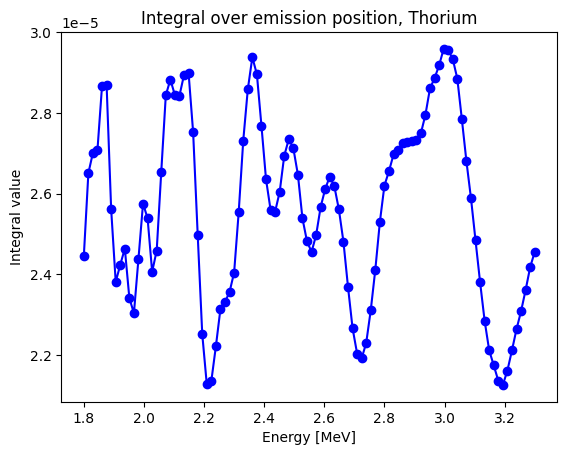

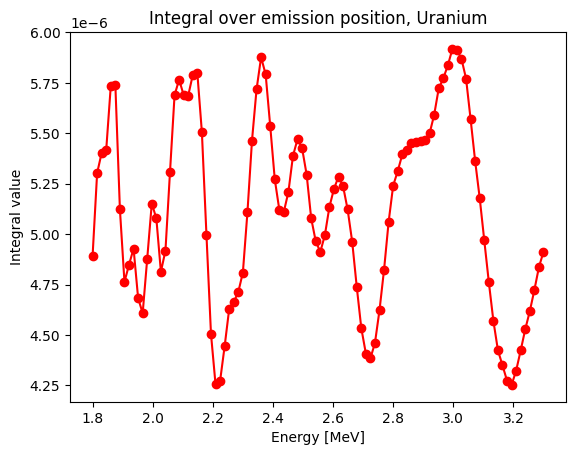

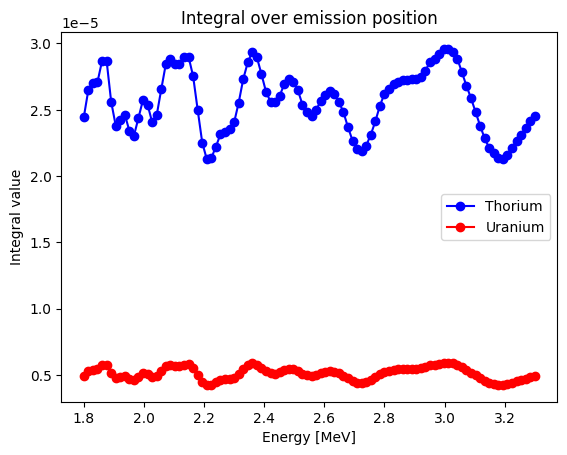

In [24]:
#make plots

#Thorium
plt.plot(energy_array, Th_integral_values, marker='o', linestyle='-', color='b')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
#plt.savefig('Integral over emission position, Thorium, standard oscillation parameters.pdf', format='pdf')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values, marker='o', linestyle='-', color='r')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
#plt.savefig('Integral over emission position, Uranium, standard oscillation parameters.pdf', format='pdf')
plt.show()

#Both together

plt.plot(energy_array, Th_integral_values, marker='o', linestyle='-', color='b', label='Thorium')
plt.plot(energy_array, U_integral_values, marker='o', linestyle='-', color='r', label='Uranium')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')
plt.legend()
#plt.savefig('Integral over emission position, standard oscillation parameters.pdf', format='pdf')
plt.show()

In [25]:
### non-optimized def of integral, optimized P_ee 

def integral_over_positions_Th_U(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th, A_U, rho):
    sum_Th = np.zeros(len(energy_array))
    sum_U = np.zeros(len(energy_array))
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    P_ee_array = P_ee_full_optimized(energy_array, points_array, theta_12, theta_13, delta_m_21_squared)

    for j in range(len(energy_array)):
        for i in range(len(points_array)):
            if relative_distance_array[i] == 0:
                print('Skipping point overlapping with SNO+')
            else:
                sum_Th[j] += P_ee_array[j][i] * ((A_Th * rho) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
            #print("computed for energy "+str(j)+" out of "+str(len(energy_array)))
       
    for j in range(len(energy_array)):
        for i in range(len(points_array)):
            if relative_distance_array[i] == 0:
                print('Skipping point overlapping with SNO+')
            else:
                sum_U[j] += P_ee_array[j][i] * ((A_U * rho) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
          

    return sum_Th, sum_U

In [26]:
Th_integral_values, U_integral_values = integral_over_positions_Th_U(crust_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th_c, A_U_c, rho_c)

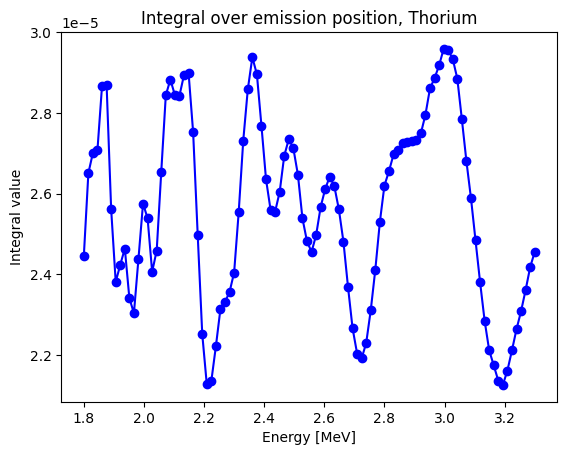

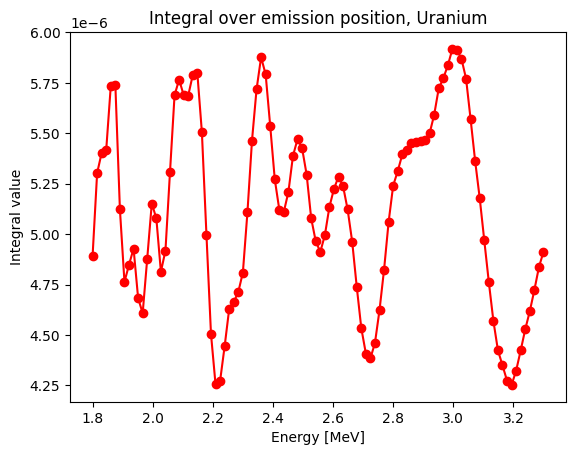

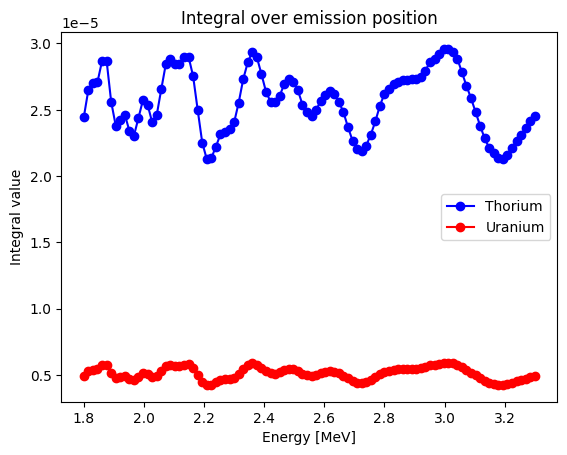

In [27]:
#make plots

#Thorium
plt.plot(energy_array, Th_integral_values, marker='o', linestyle='-', color='b')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
#plt.savefig('Integral over emission position, Thorium, standard oscillation parameters.pdf', format='pdf')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values, marker='o', linestyle='-', color='r')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
#plt.savefig('Integral over emission position, Uranium, standard oscillation parameters.pdf', format='pdf')
plt.show()

#Both together

plt.plot(energy_array, Th_integral_values, marker='o', linestyle='-', color='b', label='Thorium')
plt.plot(energy_array, U_integral_values, marker='o', linestyle='-', color='r', label='Uranium')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')
plt.legend()
#plt.savefig('Integral over emission position, standard oscillation parameters.pdf', format='pdf')
plt.show()

Great, they look the same!!! Now I can try to optimize the integral formula

In [50]:
## optimized definition of integral, non-optimized P_ee
def integral_over_positions_Th_U(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th, A_U, rho):
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    P_ee_array = P_ee_full(energy_array, points_array, theta_12, theta_13, delta_m_21_squared)

    # Compute sum_Th
    sum_Th = np.sum(P_ee_array * ((A_Th * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    
    # Compute sum_U
    sum_U = np.sum(P_ee_array * ((A_U * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)

    return sum_Th, sum_U
    

In [51]:
Th_integral_values, U_integral_values = integral_over_positions_Th_U(crust_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th_c, A_U_c, rho_c)

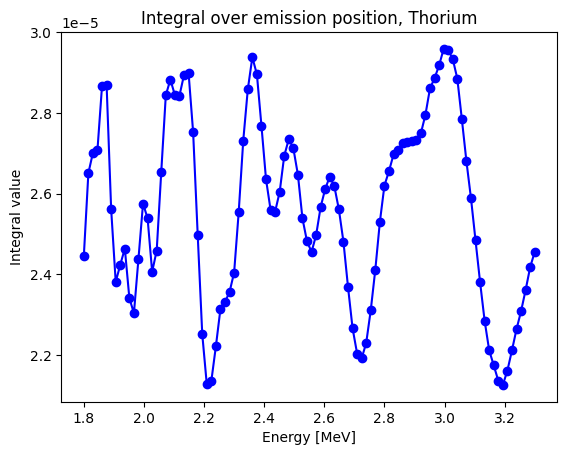

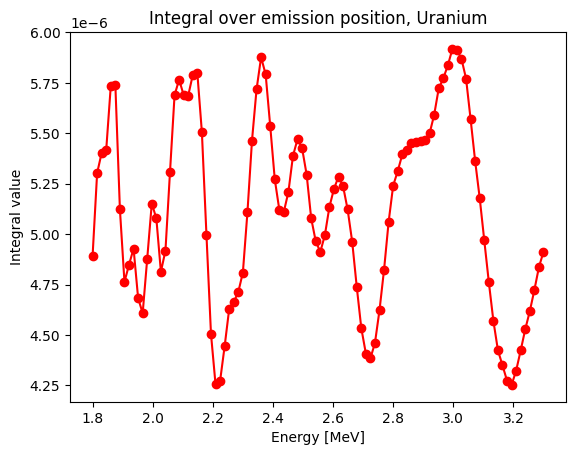

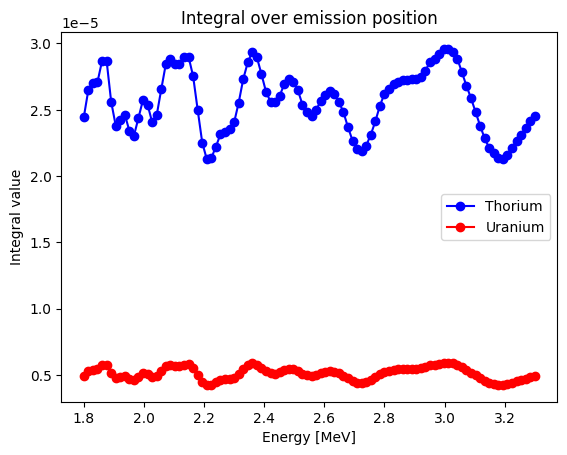

In [52]:
#make plots

#Thorium
plt.plot(energy_array, Th_integral_values, marker='o', linestyle='-', color='b')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
#plt.savefig('Integral over emission position, Thorium, standard oscillation parameters.pdf', format='pdf')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values, marker='o', linestyle='-', color='r')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
#plt.savefig('Integral over emission position, Uranium, standard oscillation parameters.pdf', format='pdf')
plt.show()

#Both together

plt.plot(energy_array, Th_integral_values, marker='o', linestyle='-', color='b', label='Thorium')
plt.plot(energy_array, U_integral_values, marker='o', linestyle='-', color='r', label='Uranium')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')
plt.legend()
#plt.savefig('Integral over emission position, standard oscillation parameters.pdf', format='pdf')
plt.show()

In [53]:
## optimized definition of integral, optimized P_ee
def integral_over_positions_Th_U(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th, A_U, rho):
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    P_ee_array = P_ee_full_optimized(energy_array, points_array, theta_12, theta_13, delta_m_21_squared)

    # Compute sum_Th
    sum_Th = np.sum(P_ee_array * ((A_Th * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    
    # Compute sum_U
    sum_U = np.sum(P_ee_array * ((A_U * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)

    return sum_Th, sum_U
    

In [54]:
Th_integral_values, U_integral_values = integral_over_positions_Th_U(crust_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th_c, A_U_c, rho_c)

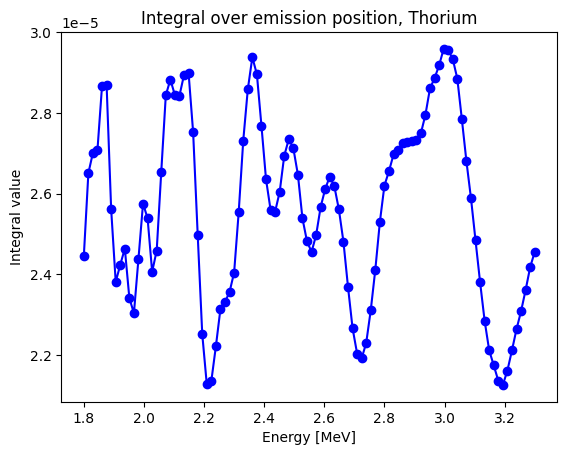

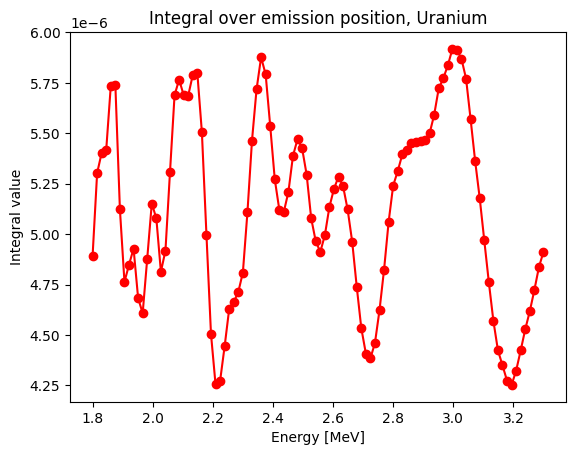

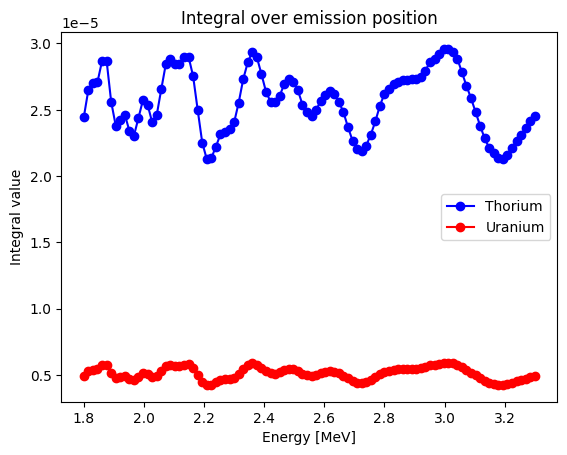

In [55]:
#make plots

#Thorium
plt.plot(energy_array, Th_integral_values, marker='o', linestyle='-', color='b')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
#plt.savefig('Integral over emission position, Thorium, standard oscillation parameters.pdf', format='pdf')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values, marker='o', linestyle='-', color='r')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
#plt.savefig('Integral over emission position, Uranium, standard oscillation parameters.pdf', format='pdf')
plt.show()

#Both together

plt.plot(energy_array, Th_integral_values, marker='o', linestyle='-', color='b', label='Thorium')
plt.plot(energy_array, U_integral_values, marker='o', linestyle='-', color='r', label='Uranium')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')
plt.legend()
#plt.savefig('Integral over emission position, standard oscillation parameters.pdf', format='pdf')
plt.show()

results:

non-optimized integral, non-optimized P_ee :  75 sec

non-optimized integral, optimized P_ee :  15 sec

optimized integral, non-optimized P_ee :  61 sec

optimized integral, optimized P_ee :  0.8 sec